# 데이터 기초 분석

공정 조건과 물성치 간의 대략적인 추세를 살펴보자.

In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import datetime

np.set_printoptions(precision=3)
pd.set_option('display.max_rows', None)
#pd.set_option("display.precision", 4)

import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
%matplotlib inline
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = [20, 16]

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio   
import plotly.express as px

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

#import env
os.getcwd()

/tmp/ipykernel_21665/141046800.py:27: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


'/home/ysg/Projects/ai_data_2022-main'

## 데이터 읽기

- 특정 실험(장비, 소재, 적층 방향 동일)의 시편 데이터들 취합하여 비교하기
- 2022-07-11 현재 json 포맷으로 정리되지 않은 정보 존재


In [2]:
base_dir = os.path.join(f'/home', 'mygenie', 'data', 'AI_DB_CYAUTOTECH',)
data_dir_1 = os.path.join(base_dir, '2.sus_0_1circle_process', 'CENTER')
base_dir = os.path.join(f'/home', 'mygenie', 'data', 'AI_DB_CYAUTOTECH', '300장비')
data_dir_2 = os.path.join(base_dir, '3.sus_0_2circle_process', 'CENTER')

In [3]:
!dir "$data_dir/IMAGE"

dir: '/IMAGE'에 접근할 수 없습니다: 그런 파일이나 디렉터리가 없습니다


In [4]:
def read_data(data_dir):
    data = {}
    json_dir = os.path.join(data_dir, 'JSON')

    for sample_id in os.listdir(json_dir):
        meta_info = None
        json_file = os.listdir(os.path.join(json_dir, sample_id))[0]
        with open(os.path.join(json_dir, sample_id, json_file), encoding='utf-8') as f:
            _info = json.load(f)
            if meta_info is None:
                meta_info = {k:set() for k in _info.keys()}
            for k, v in _info.items():
                if k != 'input 식별자 ':
                    meta_info[k].add(v)
        data[int(sample_id)] = meta_info
    return data

## 데이터 전처리

- 빈 칸 없애기, 단위 처리 등
- power 와 speed 가 정순으로 기록


In [5]:
import re
re_num = re.compile(r'([0-9\.]+)(.*)')

In [6]:
def preprocess(data): 
    materials = ['SUS']
    facilities = ['Vulcan 300']

    data_list = []
    for i in range(16):
        _data = {k.strip():list(v)[0].strip() for k, v in data[i].items() if len(v) > 0}

        __data = {}
        for k, v in _data.items():
            if k == '소재':
                __data[k] = materials.index(v)
            elif k == '장비종류':
                __data[k] = facilities.index(v)
            elif k == '적층방향' or k == '데이터셋타입':
                __data[k] = int(v)
            elif 'power' in k:
                __data['laser_speed'] = float(v)## power 와 speed 가 반대로 기록
            elif 'speed' in k:
                __data['laser_power'] = float(v) ## power 와 speed 가 반대로 기록
            else:
                val, unit = re_num.match(v).groups()
                k = k if len(unit) == 0 else f'{k}({unit})'
                __data[k] = float(val)
        data_list.append(__data)
    df = pd.DataFrame(data_list)
    df['laser_density'] = np.divide(df['laser_power'], df['laser_speed']) #df['laser_power'] / df['laser_speed']
    return df

In [7]:
list_file = [data_dir_1, data_dir_2]
list_data = list()
list_df = list()
for _file in list_file:
    _data = read_data(_file)
    _df = preprocess(_data)
    list_data.append(_data)
    list_df.append(_df)

# 데이터 분석

In [8]:
# import matplotlib.pyplot as plt
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
# plt.rcParams['font.family'] = 'Malgun Gothic'

def plot_annot(df_plot, x_col, y_cols, figsize=(24, 5), ax=list(), marker='o', color='tab:blue', alpha=0.7, offset=0.0):
    
    if len(ax) <= 0: 
        fig, ax = plt.subplots(1, len(y_cols), figsize=figsize)
    for i, c in enumerate(y_cols):
        x = df_plot[x_col]
        y = df_plot[c]
        ax[i].scatter(x, y, marker=marker, c=color, alpha=alpha)
        ax[i].set_title(c)
        ax[i].set_xlabel(x_col)

        xscale = (x.max()-x.min()) 
        yscale = (y.max()-y.min())
        xoffset = offset * xscale
        yoffset = offset * yscale
        for (_idx, _x, _y) in zip(x.index, x, y):
            ax[i].annotate(_idx, (_x+xoffset, _y+yoffset), c=color)
            

def plot_annot_comp(df_0, df_1, x_col, y_cols, figsize=(24, 5)):
    fig, ax = plt.subplots(1, len(y_cols), figsize=figsize)
    plot_annot(df_0, x_col, y_cols, figsize=figsize, ax=ax, marker='o', color='tab:blue', alpha=0.7, offset=-0.04)
    plot_annot(df_1, x_col, y_cols, figsize=figsize, ax=ax, marker='^', color='tab:red', alpha=0.7, offset=0.01)
    
#     for i, c in enumerate(y_cols):
#         x_0 = df_0[x_col]
#         y_0 = df_0[c]
#         ax[i].scatter(x_0, y_0)
#         ax[i].set_title(c)
#         ax[i].set_xlabel(x_col)

#         for (_idx, _x, _y) in zip(x_0.index, x_0, y_0):
#             ax[i].annotate(_idx, (_x, _y))

## 전체 데이터 분석

In [9]:
_idx = [True] * 16

# _idx[0] = False
# _idx[6] = False
# _idx[7] = False

# _idx[12] = False
tag_picked = ['항복강도(MPa)','인장강도(MPa)','연신율(%)','밀도','laser_power','laser_speed','laser_density']
df_0 = list_df[0][tag_picked]
df_1 = list_df[1][tag_picked]

In [10]:
df_0['trial'] = [ '1' for i in range(df_0.shape[0]) ]
df_0

/tmp/ipykernel_21665/3533291702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['trial'] = [ '1' for i in range(df_0.shape[0]) ]


,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density,trial
0,0.00,0.00,40.4,7.81,312.0,700.0,0.445714,1
1,476.22,611.24,40.4,7.82,264.0,700.0,0.377143,1
2,466.05,602.48,42.7,7.82,360.0,700.0,0.514286,1
3,483.13,599.35,40.8,7.80,408.0,700.0,0.582857,1
4,469.09,577.51,39.2,7.82,264.0,900.0,0.293333,1
5,423.57,533.57,32.7,7.82,312.0,900.0,0.346667,1
6,395.18,490.37,19.2,7.87,360.0,900.0,0.400000,1
7,390.88,502.45,23.1,7.78,408.0,900.0,0.453333,1
8,466.94,587.99,35.0,7.80,264.0,1100.0,0.240000,1
9,457.77,574.32,34.6,7.83,312.0,1100.0,0.283636,1


In [11]:
df_1['trial'] = [ '2' for i in range(df_0.shape[0]) ]
df_1

/tmp/ipykernel_21665/463091988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['trial'] = [ '2' for i in range(df_0.shape[0]) ]


,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density,trial
0,482.97,618.90,34.6,7.81,312.0,700.0,0.445714,2
1,625.85,795.83,34.6,7.82,264.0,700.0,0.377143,2
2,768.91,935.89,36.5,7.82,360.0,700.0,0.514286,2
3,477.21,623.11,36.5,7.80,408.0,700.0,0.582857,2
4,492.49,624.57,36.5,7.82,264.0,900.0,0.293333,2
5,465.91,581.00,36.5,7.82,312.0,900.0,0.346667,2
6,468.00,594.82,36.5,7.87,360.0,900.0,0.400000,2
7,526.56,643.13,34.6,7.78,408.0,900.0,0.453333,2
8,394.81,486.54,15.4,7.80,264.0,1100.0,0.240000,2
9,456.75,614.74,34.6,7.83,312.0,1100.0,0.283636,2


In [12]:
df_join = pd.concat([df_0, df_1], ignore_index=True)
df_join

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density,trial
0,0.00,0.00,40.4,7.81,312.0,700.0,0.445714,1
1,476.22,611.24,40.4,7.82,264.0,700.0,0.377143,1
2,466.05,602.48,42.7,7.82,360.0,700.0,0.514286,1
3,483.13,599.35,40.8,7.80,408.0,700.0,0.582857,1
4,469.09,577.51,39.2,7.82,264.0,900.0,0.293333,1
5,423.57,533.57,32.7,7.82,312.0,900.0,0.346667,1
6,395.18,490.37,19.2,7.87,360.0,900.0,0.400000,1
7,390.88,502.45,23.1,7.78,408.0,900.0,0.453333,1
8,466.94,587.99,35.0,7.80,264.0,1100.0,0.240000,1
9,457.77,574.32,34.6,7.83,312.0,1100.0,0.283636,1


In [13]:
df_join.describe()

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,434.963750,551.800625,30.028125,7.817500,336.000000,1000.000000,0.354312
std,134.818538,167.169205,9.944920,0.036367,54.524336,227.184734,0.103177
min,0.000000,0.000000,1.900000,7.750000,264.000000,700.000000,0.203077
25%,420.720000,527.227500,23.100000,7.797500,300.000000,850.000000,0.281958
50%,457.260000,579.255000,34.600000,7.820000,336.000000,1000.000000,0.336970
75%,476.467500,611.432500,36.500000,7.830000,372.000000,1150.000000,0.411429
max,768.910000,935.890000,42.700000,7.900000,408.000000,1300.000000,0.582857


[Text(0, 0, '0.2031'),
 Text(1, 0, '0.24'),
 Text(2, 0, '0.2769'),
 Text(3, 0, '0.2836'),
 Text(4, 0, '0.2933'),
 Text(5, 0, '0.3138'),
 Text(6, 0, '0.3273'),
 Text(7, 0, '0.3467'),
 Text(8, 0, '0.3709'),
 Text(9, 0, '0.3771'),
 Text(10, 0, '0.4'),
 Text(11, 0, '0.4457'),
 Text(12, 0, '0.4533'),
 Text(13, 0, '0.5143'),
 Text(14, 0, '0.5829')]

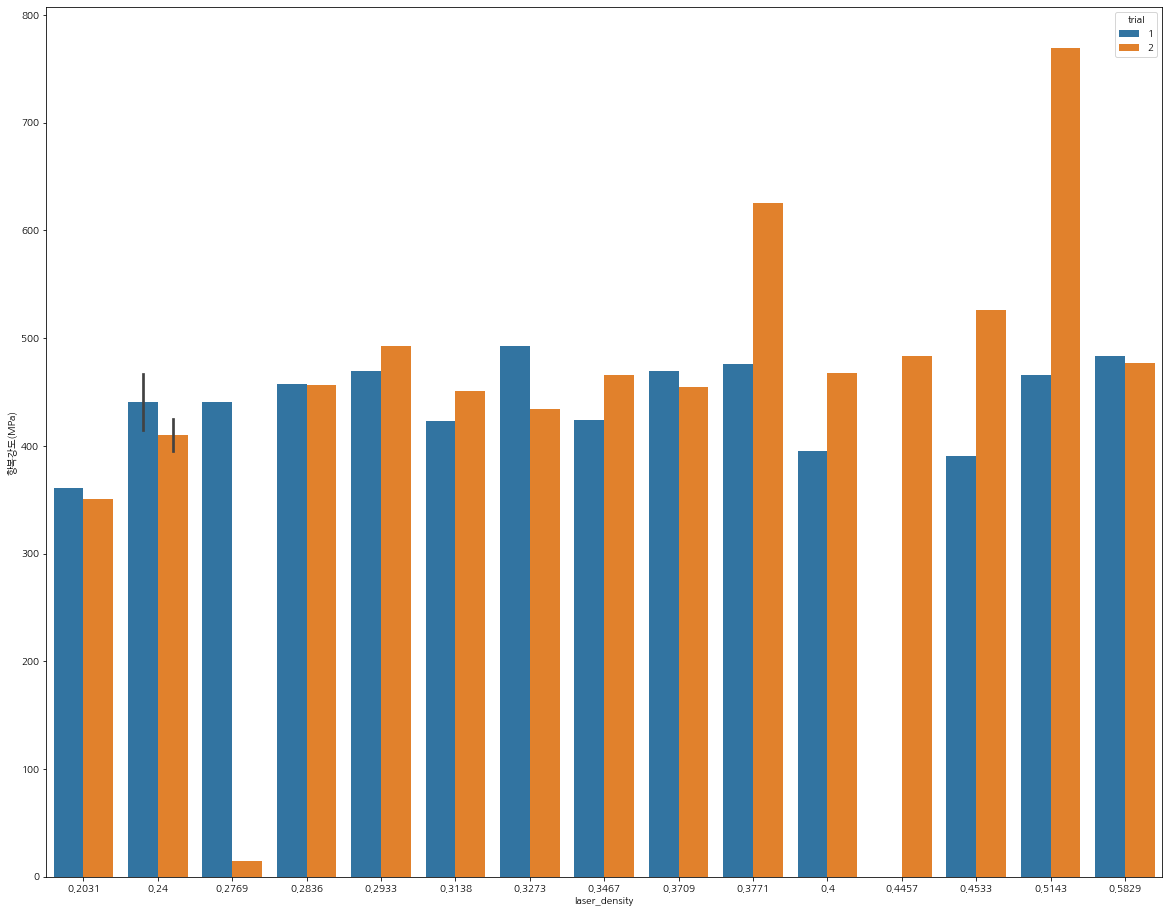

In [14]:
ax = sns.barplot(x='laser_density', y='항복강도(MPa)', hue='trial', data=df_join)
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels([str(round(float(label), 4)) for label in labels])

In [15]:
df_0.describe()

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,414.320625,523.001250,32.381250,7.817500,336.000000,1000.000000,0.354312
std,116.695618,145.645678,7.827151,0.036968,55.425626,230.940108,0.104882
min,0.000000,0.000000,19.200000,7.750000,264.000000,700.000000,0.203077
25%,409.992500,520.307500,23.625000,7.797500,300.000000,850.000000,0.281958
50%,449.095000,562.960000,34.600000,7.820000,336.000000,1000.000000,0.336970
75%,469.125000,590.830000,39.500000,7.830000,372.000000,1150.000000,0.411429
max,492.270000,612.010000,42.700000,7.900000,408.000000,1300.000000,0.582857


In [16]:
df_1.describe()

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,455.606875,580.600000,27.675000,7.817500,336.000000,1000.000000,0.354312
std,151.778949,186.472689,11.459465,0.036968,55.425626,230.940108,0.104882
min,14.700000,17.140000,1.900000,7.750000,264.000000,700.000000,0.203077
25%,431.850000,563.927500,18.925000,7.797500,300.000000,850.000000,0.281958
50%,461.330000,592.275000,34.600000,7.820000,336.000000,1000.000000,0.336970
75%,485.350000,623.475000,36.500000,7.830000,372.000000,1150.000000,0.411429
max,768.910000,935.890000,36.500000,7.900000,408.000000,1300.000000,0.582857


<AxesSubplot:>

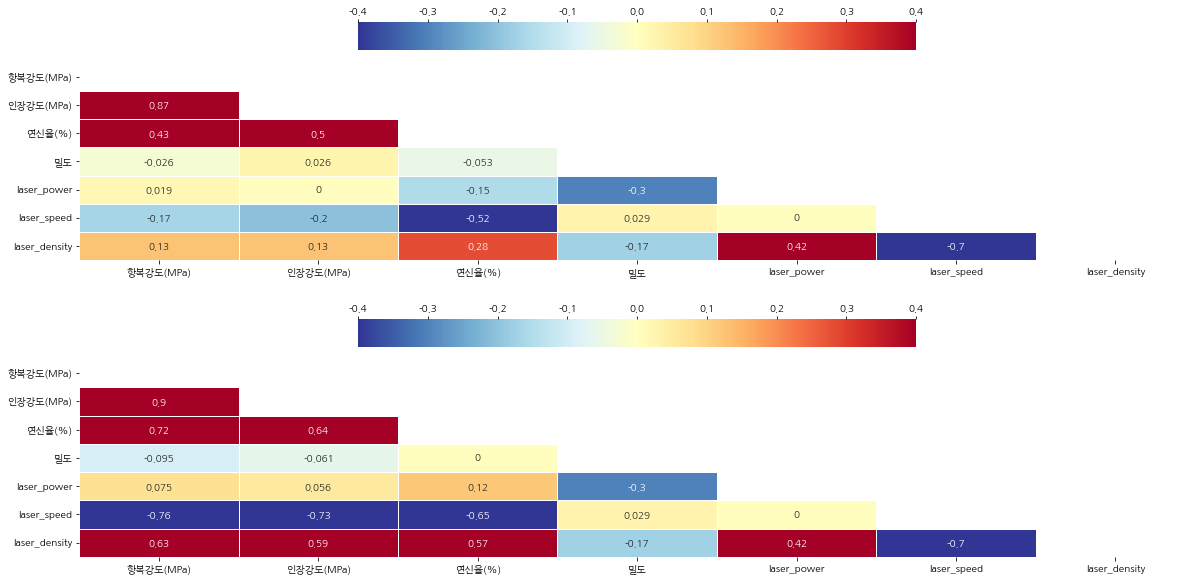

In [17]:
corr_0 = df_0.loc[_idx, :].corr(method='kendall') #.abs() #method={‘pearson’, ‘kendall’, ‘spearman’}
corr_1 = df_1.loc[_idx, :].corr(method='kendall')

# mask_0 = None ; mask_1 = None
mask_0 = np.zeros_like(corr_0, dtype=np.bool_)
mask_0[np.triu_indices_from(mask_0)] = True
mask_1 = np.zeros_like(corr_1, dtype=np.bool_)
mask_1[np.triu_indices_from(mask_1)] = True

fig, axes = plt.subplots(2,1, figsize=(20, 10))
axes = axes.flatten()
sns.heatmap(corr_0, cmap = 'RdYlBu_r', ax=axes[0], annot=True, vmin = -0.4, vmax = 0.4, mask=mask_0, linewidth=.5, cbar_kws={"location": 'top', "shrink": .5})
sns.heatmap(corr_1, cmap = 'RdYlBu_r', ax=axes[1], annot=True, vmin = -0.4, vmax = 0.4, mask=mask_1, linewidth=.5, cbar_kws={"location": 'top', "shrink": .5})

### 공정변수 vs 기계적 특성치 분포

In [18]:
y_cols = ['항복강도(MPa)','인장강도(MPa)','연신율(%)','밀도']

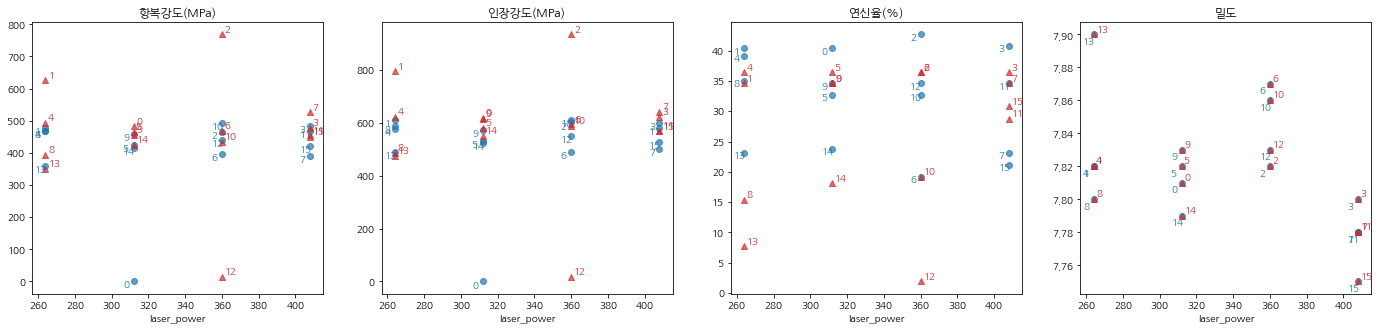

In [19]:
plot_annot_comp(df_0, df_1, 'laser_power', y_cols)

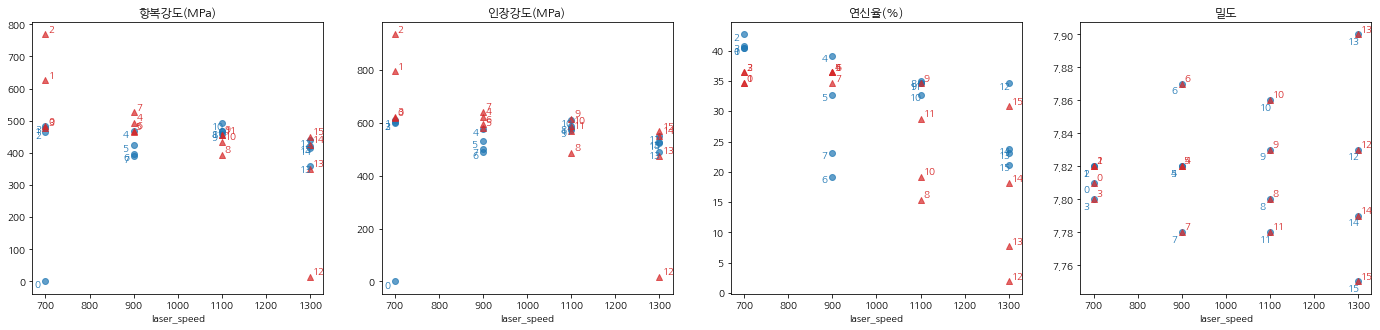

In [20]:
plot_annot_comp(df_0, df_1, 'laser_speed', y_cols)

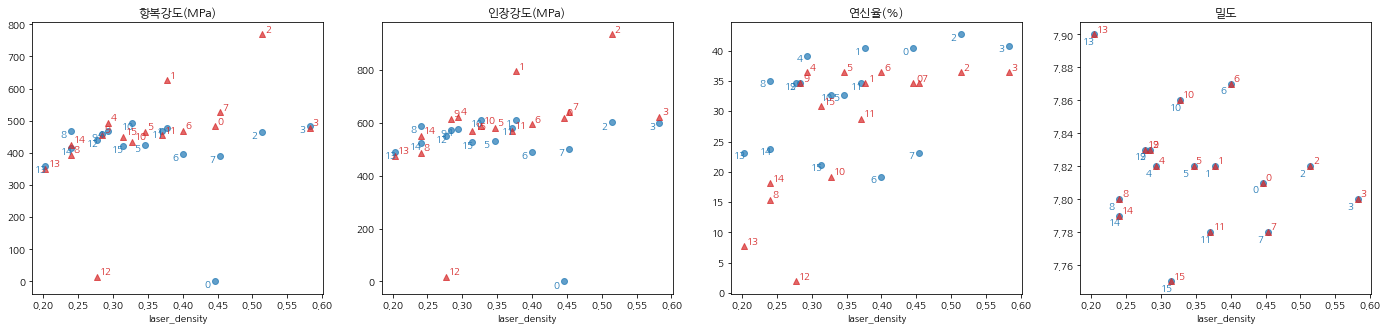

In [21]:
plot_annot_comp(df_0, df_1, 'laser_density', y_cols)

### 밀도 vs 타 특성치 분포

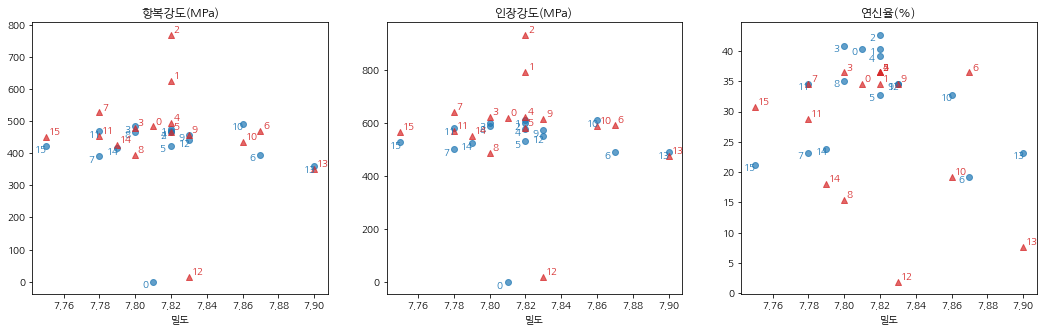

In [22]:
y_cols = ['항복강도(MPa)','인장강도(MPa)','연신율(%)']
plot_annot_comp(df_0, df_1, '밀도', y_cols, figsize=(18, 5))

## 이상치 제외 데이터 분석 (#1: 0, 6, 7 번 제외)

In [23]:
_idx_0 = [True] * 16

_idx_0[0] = False
_idx_0[6] = False
_idx_0[7] = False

df_corr_0 = df_0.loc[_idx_0, :].corr()
df_corr_0

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
항복강도(MPa),1.000000,0.965128,0.769784,-0.268857,0.248466,-0.599208,0.548186
인장강도(MPa),0.965128,1.000000,0.826528,-0.124456,0.145424,-0.685406,0.582662
연신율(%),0.769784,0.826528,1.000000,0.029223,-0.019731,-0.842839,0.647643
밀도,-0.268857,-0.124456,0.029223,1.000000,-0.482941,0.033864,-0.252509
laser_power,0.248466,0.145424,-0.019731,-0.482941,1.000000,0.031819,0.554883
laser_speed,-0.599208,-0.685406,-0.842839,0.033864,0.031819,1.000000,-0.788467
laser_density,0.548186,0.582662,0.647643,-0.252509,0.554883,-0.788467,1.000000


## 이상치 제외 데이터 분석 (#2: 1, 2, 12 번 제외)

In [24]:
_idx_1 = [True] * 16

_idx_1[1] = False
_idx_1[2] = False
_idx_1[12] = False

df_corr_1 = df_1.loc[_idx_1, :].corr()
df_corr_1

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
항복강도(MPa),1.000000,0.937090,0.896083,-0.447572,0.493736,-0.689127,0.700689
인장강도(MPa),0.937090,1.000000,0.861621,-0.261614,0.468340,-0.673429,0.697223
연신율(%),0.896083,0.861621,1.000000,-0.336528,0.410817,-0.706582,0.672455
밀도,-0.447572,-0.261614,-0.336528,1.000000,-0.478544,0.020898,-0.262043
laser_power,0.493736,0.468340,0.410817,-0.478544,1.000000,-0.153735,0.669137
laser_speed,-0.689127,-0.673429,-0.706582,0.020898,-0.153735,1.000000,-0.808584
laser_density,0.700689,0.697223,0.672455,-0.262043,0.669137,-0.808584,1.000000


<AxesSubplot:>

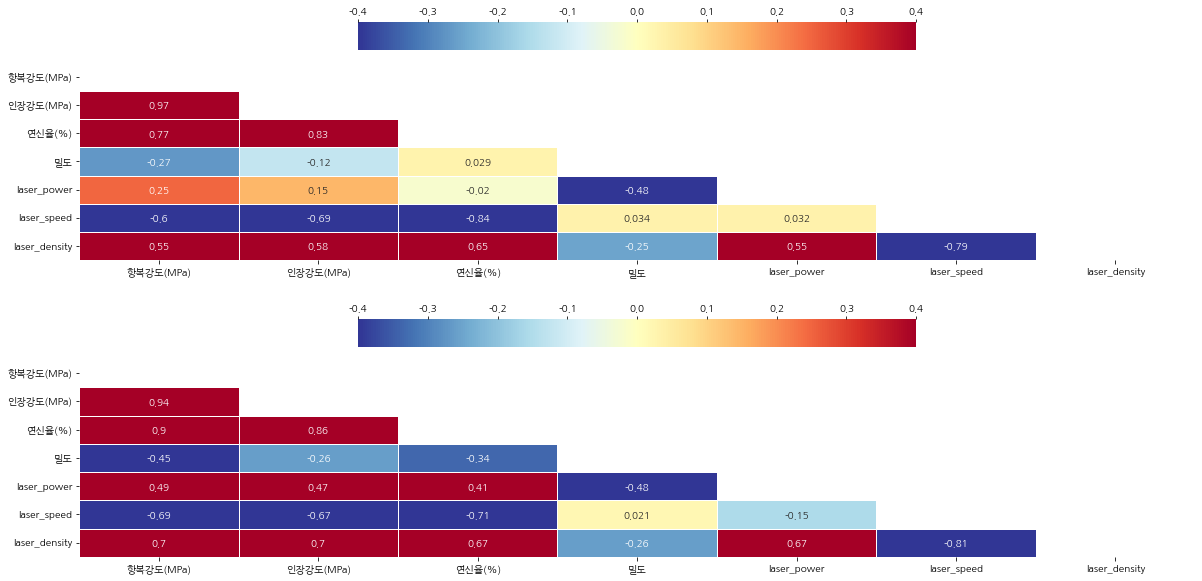

In [25]:
# mask_0 = None ; mask_1 = None
mask_0 = np.zeros_like(df_corr_0, dtype=np.bool_)
mask_0[np.triu_indices_from(mask_0)] = True
mask_1 = np.zeros_like(df_corr_1, dtype=np.bool_)
mask_1[np.triu_indices_from(mask_1)] = True

fig, axes = plt.subplots(2,1, figsize=(20, 10))
axes = axes.flatten()
sns.heatmap(df_corr_0, cmap = 'RdYlBu_r', ax=axes[0], annot=True, vmin = -0.4, vmax = 0.4, mask=mask_0, linewidth=.5, cbar_kws={"location": 'top', "shrink": .5})
sns.heatmap(df_corr_1, cmap = 'RdYlBu_r', ax=axes[1], annot=True, vmin = -0.4, vmax = 0.4, mask=mask_1, linewidth=.5, cbar_kws={"location": 'top', "shrink": .5})

### 공정변수 vs 기계적 특성치 분포

In [26]:
y_cols = df_0.columns[:4].tolist()
df_0_t = df_0.loc[_idx_0, :]
df_1_t = df_1.loc[_idx_1, :]


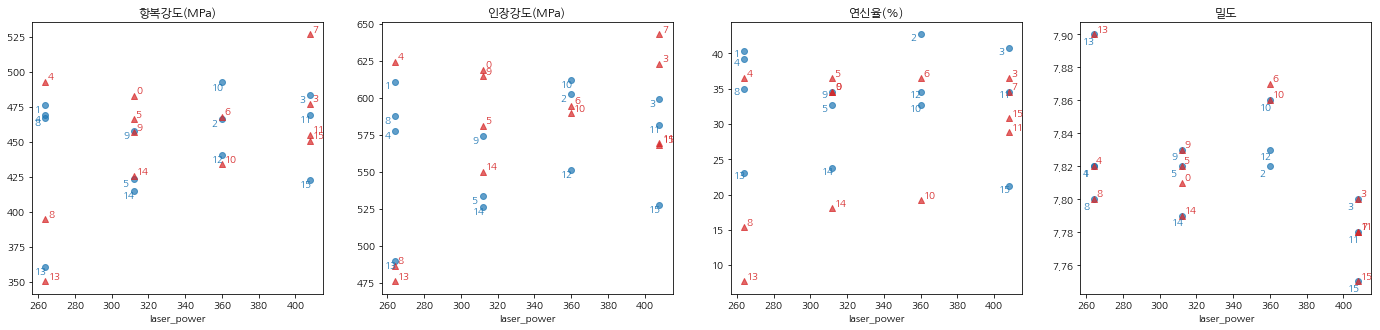

In [27]:
plot_annot_comp(df_0_t, df_1_t, 'laser_power', y_cols)

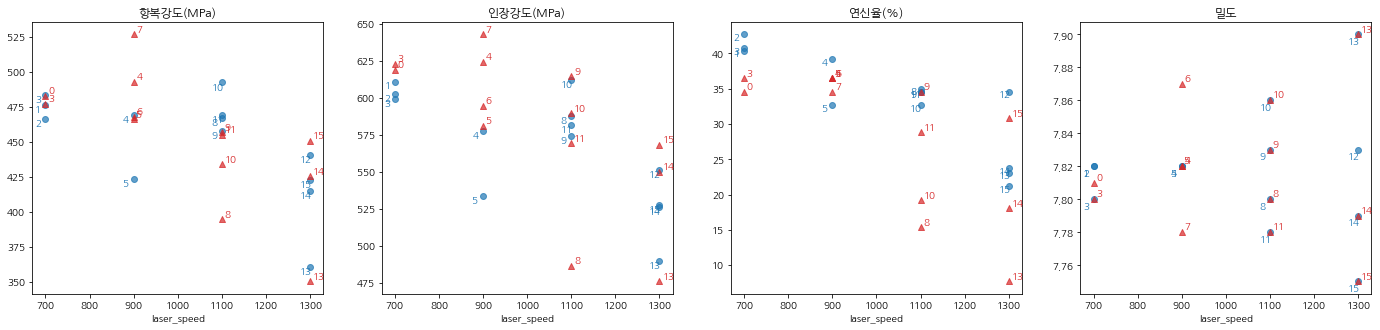

In [28]:
plot_annot_comp(df_0_t, df_1_t,  'laser_speed', y_cols)

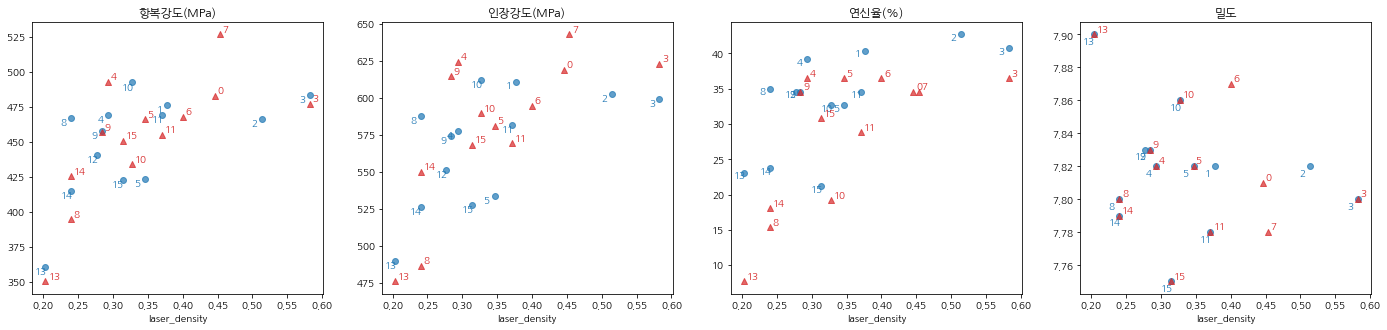

In [29]:
plot_annot_comp(df_0_t, df_1_t,  'laser_density', y_cols)

### 밀도 vs 타 특성치 분포

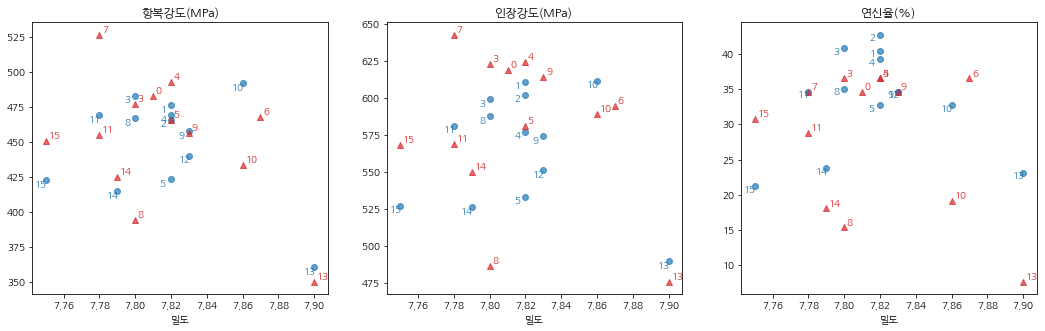

In [30]:
y_cols = df_0.columns[:3].tolist()

plot_annot_comp(df_0_t, df_1_t,  '밀도', y_cols, figsize=(18, 5))